# Models Comparison for TinyML

In [56]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
from pandas import read_csv
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import m2cgen as m2c
from micromlgen import port

import warnings
import sys
import seaborn as sbs

warnings.filterwarnings('ignore')

In [74]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)

## Change 'chosenIndex' to change the chosen Test (s/s3/s6)

In [84]:
dataXPath = ['../data/X.pkl', '../data/XS3.pkl', '../data/XS6.pkl']
dataYPath = ['../data/y.pkl', '../data/yS3.pkl', '../data/yS6.pkl']
chosenIndex = 1

with open(dataXPath[chosenIndex], 'rb') as f:
    X = pickle.load(f)

with open(dataYPath[chosenIndex], 'rb') as f:
    y = pickle.load(f)

In [85]:
X = np.concatenate((X[:250], X[750:1000], X[1500:]), axis=0)
y = np.concatenate((y[:250], y[750:1000], y[1500:]), axis=0)

In [86]:
labels = []
for el in y:
    if el == 2000:
        labels.append(0)
    elif el == 2200:
        labels.append(1)
    else:
        labels.append(2)
y = labels
y = np.array(y)
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

## Model Spotting

In [88]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'f1_macro'


In [89]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression(random_state=seed))])))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , Pipeline([('Scaler', StandardScaler()), ('SVC', SVC(gamma=0.05, random_state=seed))])))
models.append(('RF', RandomForestClassifier(random_state=seed, n_estimators = 50)))


In [90]:
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 1,00 0,00
LR - 1,00 0,00
CART - 1,00 0,00
SVC - 1,00 0,00
RF - 1,00 0,00


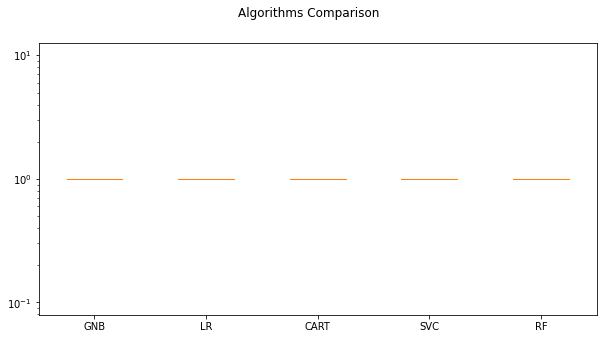

In [91]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_yscale('log')
ax.set_xticklabels(names)
plt.show()

Valutazione dei migliori algoritmi su test

# Valutazione Inferance Rate medio (|X_test| = 50/50/100)

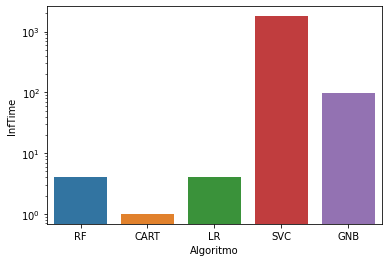

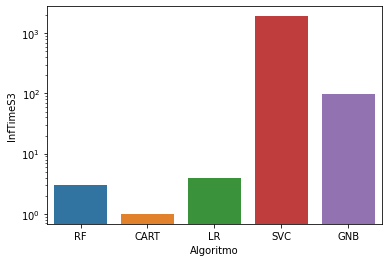

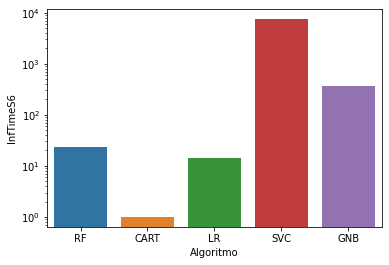

In [92]:
columns = ['InfTime', 'InfTimeS3', 'InfTimeS6']
for c in columns:
    csv = read_csv("InfTimeReport.csv")
    g = sbs.barplot(x=csv['Algoritmo'], y=csv[c])
    g.set_yscale("log")
    plt.ylabel(c)
    plt.show()


# Memoria occupata

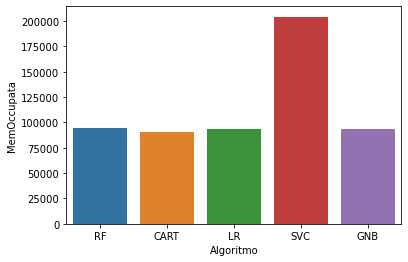

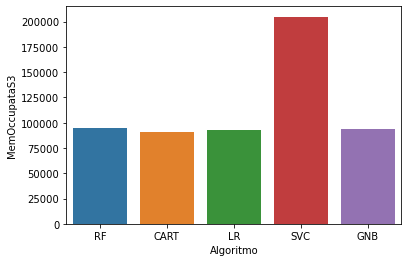

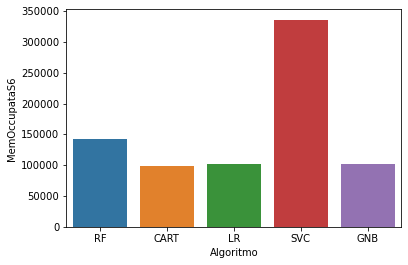

In [93]:
columns = ['MemOccupata', 'MemOccupataS3', 'MemOccupataS6']
for c in columns:   
    csv = read_csv("MemOccupationReport.csv")
    g = sbs.barplot(x=csv['Algoritmo'], y=csv[c])
    plt.ylabel(c)
    plt.show()

# Neural Network

In [169]:
n = 100
model = Sequential(name="Sequential-NN")
model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
model.add(layers.Dense(np.unique(y).size * n, activation='relu'))
model.add(layers.Dense(np.unique(y).size, activation='softmax'))
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


# Convert to array[int]
y_train = np.array([int(num) for num in y_train])
y_test = np.array([int(num) for num in y_test])

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_88 (Dense)             (None, 300)               9900      
_________________________________________________________________
dense_89 (Dense)             (None, 3)                 903       
Total params: 11,859
Trainable params: 11,859
Non-trainable params: 0
_________________________________________________________________


# Train and Test

In [170]:
EPOCHS = 1400
BATCH_SIZE = 8

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
print(classification_report(y_test, pred)

Epoch 1/1400
19/19 [==============================] - 0s 5ms/step - loss: 444.3227 - accuracy: 0.3800 - val_loss: 389.8265 - val_accuracy: 0.2600
Epoch 2/1400
19/19 [==============================] - 0s 1ms/step - loss: 225.3145 - accuracy: 0.3800 - val_loss: 60.5041 - val_accuracy: 0.5000
Epoch 3/1400
19/19 [==============================] - 0s 600us/step - loss: 103.5951 - accuracy: 0.3867 - val_loss: 191.4955 - val_accuracy: 0.2000
Epoch 4/1400
19/19 [==============================] - 0s 761us/step - loss: 84.8883 - accuracy: 0.3933 - val_loss: 41.0067 - val_accuracy: 0.2000
Epoch 5/1400
19/19 [==============================] - 0s 1ms/step - loss: 97.9414 - accuracy: 0.3800 - val_loss: 116.8179 - val_accuracy: 0.5200
Epoch 6/1400
19/19 [==============================] - 0s 1ms/step - loss: 97.2660 - accuracy: 0.3467 - val_loss: 124.9363 - val_accuracy: 0.2000
Epoch 7/1400
19/19 [==============================] - 0s 701us/step - loss: 95.2825 - accuracy: 0.3933 - val_loss: 131.3054 -

Epoch 112/1400
19/19 [==============================] - 0s 1ms/step - loss: 1.0073 - accuracy: 0.5200 - val_loss: 3.3128 - val_accuracy: 0.2000
Epoch 113/1400
19/19 [==============================] - 0s 705us/step - loss: 0.9163 - accuracy: 0.6200 - val_loss: 2.3619 - val_accuracy: 0.4400
Epoch 114/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.9803 - accuracy: 0.6200 - val_loss: 2.8709 - val_accuracy: 0.2600
Epoch 115/1400
19/19 [==============================] - 0s 514us/step - loss: 1.2514 - accuracy: 0.4933 - val_loss: 2.4514 - val_accuracy: 0.6600
Epoch 116/1400
19/19 [==============================] - 0s 699us/step - loss: 1.2871 - accuracy: 0.5467 - val_loss: 3.7245 - val_accuracy: 0.5000
Epoch 117/1400
19/19 [==============================] - 0s 2ms/step - loss: 1.4196 - accuracy: 0.4667 - val_loss: 2.3209 - val_accuracy: 0.4000
Epoch 118/1400
19/19 [==============================] - 0s 1ms/step - loss: 1.2472 - accuracy: 0.4667 - val_loss: 3.5278 - val_acc

Epoch 225/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.7417 - accuracy: 0.7600 - val_loss: 1.2010 - val_accuracy: 0.7600
Epoch 226/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.7265 - accuracy: 0.7467 - val_loss: 1.1955 - val_accuracy: 0.6600
Epoch 227/1400
19/19 [==============================] - 0s 583us/step - loss: 0.6229 - accuracy: 0.8200 - val_loss: 1.3962 - val_accuracy: 0.7000
Epoch 228/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.6190 - accuracy: 0.8200 - val_loss: 1.6473 - val_accuracy: 0.6200
Epoch 229/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.7483 - accuracy: 0.6800 - val_loss: 1.9683 - val_accuracy: 0.3600
Epoch 230/1400
19/19 [==============================] - 0s 720us/step - loss: 0.6813 - accuracy: 0.7200 - val_loss: 1.5605 - val_accuracy: 0.7000
Epoch 231/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.6386 - accuracy: 0.8133 - val_loss: 1.6675 - val_accur

19/19 [==============================] - 0s 1ms/step - loss: 0.7273 - accuracy: 0.7133 - val_loss: 1.2091 - val_accuracy: 0.7000
Epoch 338/1400
19/19 [==============================] - 0s 668us/step - loss: 0.5529 - accuracy: 0.7667 - val_loss: 1.3909 - val_accuracy: 0.4200
Epoch 339/1400
19/19 [==============================] - 0s 809us/step - loss: 0.6958 - accuracy: 0.7533 - val_loss: 1.0925 - val_accuracy: 0.7000
Epoch 340/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.6824 - accuracy: 0.7400 - val_loss: 1.5203 - val_accuracy: 0.3400
Epoch 341/1400
19/19 [==============================] - 0s 709us/step - loss: 0.5607 - accuracy: 0.8000 - val_loss: 1.2601 - val_accuracy: 0.6800
Epoch 342/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.6290 - accuracy: 0.7467 - val_loss: 1.1013 - val_accuracy: 0.7000
Epoch 343/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.5487 - accuracy: 0.8000 - val_loss: 1.2197 - val_accuracy: 0.7000
E

19/19 [==============================] - 0s 1ms/step - loss: 0.5164 - accuracy: 0.8067 - val_loss: 2.2448 - val_accuracy: 0.2800
Epoch 450/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.5786 - accuracy: 0.7867 - val_loss: 1.1826 - val_accuracy: 0.5400
Epoch 451/1400
19/19 [==============================] - 0s 701us/step - loss: 0.5028 - accuracy: 0.8200 - val_loss: 1.4020 - val_accuracy: 0.7000
Epoch 452/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.4599 - accuracy: 0.8333 - val_loss: 1.4376 - val_accuracy: 0.6600
Epoch 453/1400
19/19 [==============================] - 0s 539us/step - loss: 0.5760 - accuracy: 0.7267 - val_loss: 1.2810 - val_accuracy: 0.7000
Epoch 454/1400
19/19 [==============================] - 0s 976us/step - loss: 0.4940 - accuracy: 0.8200 - val_loss: 1.1890 - val_accuracy: 0.7000
Epoch 455/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.5747 - accuracy: 0.7400 - val_loss: 1.2477 - val_accuracy: 0.9000
E

Epoch 562/1400
19/19 [==============================] - 0s 816us/step - loss: 0.4197 - accuracy: 0.8467 - val_loss: 1.3861 - val_accuracy: 0.7000
Epoch 563/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.3413 - accuracy: 0.8800 - val_loss: 1.2569 - val_accuracy: 0.9200
Epoch 564/1400
19/19 [==============================] - 0s 609us/step - loss: 0.4828 - accuracy: 0.8067 - val_loss: 2.1654 - val_accuracy: 0.7000
Epoch 565/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.7320 - accuracy: 0.7867 - val_loss: 2.1031 - val_accuracy: 0.7000
Epoch 566/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.5875 - accuracy: 0.8067 - val_loss: 1.5497 - val_accuracy: 0.7400
Epoch 567/1400
19/19 [==============================] - 0s 555us/step - loss: 0.7926 - accuracy: 0.6467 - val_loss: 1.7334 - val_accuracy: 0.6400
Epoch 568/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.5729 - accuracy: 0.7467 - val_loss: 1.3019 - val_acc

19/19 [==============================] - 0s 1ms/step - loss: 0.3394 - accuracy: 0.9133 - val_loss: 2.0280 - val_accuracy: 0.7000
Epoch 675/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.4530 - accuracy: 0.8533 - val_loss: 1.6973 - val_accuracy: 0.7000
Epoch 676/1400
19/19 [==============================] - 0s 701us/step - loss: 0.5609 - accuracy: 0.7533 - val_loss: 2.1684 - val_accuracy: 0.6800
Epoch 677/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.4246 - accuracy: 0.8067 - val_loss: 1.6531 - val_accuracy: 0.6800
Epoch 678/1400
19/19 [==============================] - 0s 519us/step - loss: 0.6162 - accuracy: 0.7333 - val_loss: 1.2415 - val_accuracy: 0.8800
Epoch 679/1400
19/19 [==============================] - 0s 763us/step - loss: 0.4080 - accuracy: 0.8467 - val_loss: 1.3050 - val_accuracy: 0.9200
Epoch 680/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.5820 - accuracy: 0.7733 - val_loss: 1.3161 - val_accuracy: 0.9000
E

Epoch 787/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.2689 - accuracy: 0.8933 - val_loss: 1.1326 - val_accuracy: 0.6600
Epoch 788/1400
19/19 [==============================] - 0s 623us/step - loss: 0.3450 - accuracy: 0.8267 - val_loss: 1.0662 - val_accuracy: 0.9000
Epoch 789/1400
19/19 [==============================] - 0s 2ms/step - loss: 0.5455 - accuracy: 0.7867 - val_loss: 1.0458 - val_accuracy: 0.9600
Epoch 790/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.6058 - accuracy: 0.7733 - val_loss: 1.2668 - val_accuracy: 0.7000
Epoch 791/1400
19/19 [==============================] - 0s 562us/step - loss: 0.4841 - accuracy: 0.7733 - val_loss: 1.2136 - val_accuracy: 0.6000
Epoch 792/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.6409 - accuracy: 0.6733 - val_loss: 1.0121 - val_accuracy: 0.9600
Epoch 793/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.2419 - accuracy: 0.9400 - val_loss: 1.2795 - val_accur

Epoch 900/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.4822 - accuracy: 0.8067 - val_loss: 1.3229 - val_accuracy: 0.7200
Epoch 901/1400
19/19 [==============================] - 0s 498us/step - loss: 0.4349 - accuracy: 0.8667 - val_loss: 1.2243 - val_accuracy: 0.7200
Epoch 902/1400
19/19 [==============================] - 0s 734us/step - loss: 0.7896 - accuracy: 0.7333 - val_loss: 2.5744 - val_accuracy: 0.5800
Epoch 903/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.9858 - accuracy: 0.6733 - val_loss: 2.9200 - val_accuracy: 0.4600
Epoch 904/1400
19/19 [==============================] - 0s 877us/step - loss: 0.6623 - accuracy: 0.7600 - val_loss: 1.3429 - val_accuracy: 0.7600
Epoch 905/1400
19/19 [==============================] - 0s 774us/step - loss: 0.2897 - accuracy: 0.8800 - val_loss: 0.9736 - val_accuracy: 0.9800
Epoch 906/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.2314 - accuracy: 0.9400 - val_loss: 0.9907 - val_a

19/19 [==============================] - 0s 1ms/step - loss: 0.1195 - accuracy: 0.9933 - val_loss: 0.9737 - val_accuracy: 0.9800
Epoch 1013/1400
19/19 [==============================] - 0s 567us/step - loss: 0.1657 - accuracy: 0.9600 - val_loss: 1.0991 - val_accuracy: 0.9600
Epoch 1014/1400
19/19 [==============================] - 0s 819us/step - loss: 0.1538 - accuracy: 0.9733 - val_loss: 0.9942 - val_accuracy: 0.9800
Epoch 1015/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.1498 - accuracy: 0.9800 - val_loss: 1.0083 - val_accuracy: 0.9800
Epoch 1016/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.1967 - accuracy: 0.9200 - val_loss: 1.1169 - val_accuracy: 0.8000
Epoch 1017/1400
19/19 [==============================] - 0s 710us/step - loss: 0.2425 - accuracy: 0.9067 - val_loss: 0.9998 - val_accuracy: 0.9800
Epoch 1018/1400
19/19 [==============================] - 0s 2ms/step - loss: 0.3661 - accuracy: 0.8467 - val_loss: 1.0452 - val_accuracy: 0.

19/19 [==============================] - 0s 699us/step - loss: 0.1196 - accuracy: 0.9800 - val_loss: 1.2577 - val_accuracy: 0.9600
Epoch 1125/1400
19/19 [==============================] - 0s 765us/step - loss: 0.1122 - accuracy: 0.9800 - val_loss: 1.1383 - val_accuracy: 0.9600
Epoch 1126/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.1089 - accuracy: 0.9867 - val_loss: 1.1603 - val_accuracy: 0.8800
Epoch 1127/1400
19/19 [==============================] - 0s 534us/step - loss: 0.0948 - accuracy: 0.9867 - val_loss: 1.1469 - val_accuracy: 0.9600
Epoch 1128/1400
19/19 [==============================] - 0s 768us/step - loss: 0.0940 - accuracy: 0.9867 - val_loss: 1.1213 - val_accuracy: 0.9600
Epoch 1129/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.1221 - accuracy: 0.9800 - val_loss: 1.1603 - val_accuracy: 0.9600
Epoch 1130/1400
19/19 [==============================] - 0s 605us/step - loss: 0.1162 - accuracy: 0.9733 - val_loss: 1.3736 - val_accuracy

19/19 [==============================] - 0s 1ms/step - loss: 0.4069 - accuracy: 0.8133 - val_loss: 1.6530 - val_accuracy: 0.8400
Epoch 1237/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.2151 - accuracy: 0.9200 - val_loss: 1.8890 - val_accuracy: 0.9200
Epoch 1238/1400
19/19 [==============================] - 0s 653us/step - loss: 0.1332 - accuracy: 0.9867 - val_loss: 1.6344 - val_accuracy: 0.9600
Epoch 1239/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.1164 - accuracy: 0.9933 - val_loss: 1.6792 - val_accuracy: 0.9600
Epoch 1240/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.1478 - accuracy: 0.9800 - val_loss: 1.6717 - val_accuracy: 0.9600
Epoch 1241/1400
19/19 [==============================] - 0s 662us/step - loss: 0.2151 - accuracy: 0.9267 - val_loss: 1.6882 - val_accuracy: 0.9600
Epoch 1242/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.1725 - accuracy: 0.9667 - val_loss: 1.7115 - val_accuracy: 0.96

19/19 [==============================] - 0s 1ms/step - loss: 0.1620 - accuracy: 0.9600 - val_loss: 2.6594 - val_accuracy: 0.7800
Epoch 1349/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.1288 - accuracy: 0.9800 - val_loss: 2.4488 - val_accuracy: 0.8800
Epoch 1350/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.1596 - accuracy: 0.9600 - val_loss: 2.4240 - val_accuracy: 0.8600
Epoch 1351/1400
19/19 [==============================] - 0s 666us/step - loss: 0.5306 - accuracy: 0.7667 - val_loss: 2.5273 - val_accuracy: 0.9600
Epoch 1352/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.4463 - accuracy: 0.7400 - val_loss: 3.2195 - val_accuracy: 0.6800
Epoch 1353/1400
19/19 [==============================] - 0s 568us/step - loss: 0.6140 - accuracy: 0.7600 - val_loss: 2.6489 - val_accuracy: 0.7600
Epoch 1354/1400
19/19 [==============================] - 0s 1ms/step - loss: 0.3050 - accuracy: 0.8667 - val_loss: 2.5655 - val_accuracy: 0.70

# Export Models in C code

In [41]:
# Models in Pipeline
modelsInPipeline = []
modelsInPipeline.append('LR')
modelsInPipeline.append('SVC')

In [25]:
directories = ['s/', 's3/', 's6/']
for name, model in models:
    prepath = 'exportedModels/' + directories[chosenIndex]
    path = prepath + name + '.h'
    if name in modelsInPipeline:
        model = model[1]
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))